## FeedForwardNetwork(FFN)

Some functions will be used that were previously defined in Data Exploration file.

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

C:\Users\DEVARSHI\Anaconda3\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\DEVARSHI\Anaconda3\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Here we are using feature extraction methods by appling librosa python library. The Methods involved are:

- Mel-frequency cepstral coefficients (MFCC): representation of the short-term power spectrum of a sound
- melspectrogram: Coefficients that collectively make up an mel-frequency cepstrum
- Chromagram of a short-time Fourier transform (chroma_stft): Projects into bins representing the 12 distinct semitones of the musical octave
- spectral_contrast (Octave-based spectral contrast) : Distribution of sound energy over octave frequencies 
- Tonnetz: Estimates tonal centroids features

In [2]:
def extract_features(file_name):
    X, sr = librosa.load(file_name)
    stft = np.abs(librosa.stft(X)) #Short-time Fourier transform (STFT)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_file(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    return features

Now lets test the dimensionality reduction with a sample file

In [3]:
def sample(filename):
    data_points, _ = librosa.load(filename)
    print ("Initial Data Points:", len(data_points))
    print('-'*30)
    
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    all_features = np.hstack((mfccs,chroma,mel,contrast,tonnetz))
    print ("MFCSS features: ", len(mfccs))
    print ("Chroma features: ", len(chroma))
    print ("Mel spectogram features: ", len(mel))
    print ("Contrast features: ", len(contrast))
    print ("Tonnetz features: ", len(tonnetz))
    print ("Combined extracted features:", len(all_features))

test = r'C:\Users\DEVARSHI\Desktop\heartbeats-master\heartbeats-master\data\physionet\training-a\a0001.wav'
sample(test)

Initial Data Points: 786436
------------------------------
MFCSS features:  40
Chroma features:  12
Mel spectogram features:  128
Contrast features:  7
Tonnetz features:  6
Combined extracted features: 193


- 5 features will result in a vector of 193 value. This vector will always have the same length even if the audio files are of different length. 

- As it can be observed the input sound file had 786436 data point which is derived from sampaling rate of 22050 and it was reduced to 193 dimention points.

In [4]:
def parse_files(paths):
    
    save_path = os.path.join('data', 'physionet', 'reduced_features') # It will make new folder named reduced_features 
                                                                      # and saves .npy file 
    for path, df_name in paths:
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['file', 'target'])
        df['file'] = df['file'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['features'] = df['file'].apply(parse_file)
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        
        feature_file = os.path.join(save_path, df_name + '_x.npy')
        label_file = os.path.join(save_path, df_name + '_y.npy')
        np.save(feature_file, np.array(df['features'].tolist()))
        np.save(label_file, np.array(df['target'].tolist()))
        
paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
         (os.path.join('data', 'physionet', 'training-b'), 'df_b'), 
         (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
         (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
         (os.path.join('data', 'physionet', 'training-e'), 'df_e')]


#parse_files(paths)    # comment out this if you already have reduce feature files.

In [5]:
npfiles = [('df_a_x.npy','df_a_y.npy'),
           ('df_b_x.npy','df_b_y.npy'),
           ('df_c_x.npy','df_c_y.npy'),
           ('df_d_x.npy','df_d_y.npy'),
           ('df_e_x.npy','df_e_y.npy')]

data_save = r'C:\Users\DEVARSHI\Desktop\heartbeats-master\heartbeats-master\data\physionet\reduced_features'

from tqdm import tqdm

def load_npfiles(npfiles):
    concatenate = False
    for x, y in tqdm(npfiles):
        loaded_features = np.load(os.path.join(data_save, x))
        loaded_labels = np.load(os.path.join(data_save, y))
       
        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.10it/s]


### Training Neural Network

First we will split the dataset into training and testing.

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf
import keras.backend as K
from tensorflow.keras import initializers


def create_model(dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (193,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [8]:
model = create_model()

Here 3 layers are used, in which first and second layer has 32 neurons with dense connections and last layer has 1 neuron. Activation fuctionis relu and sigmoid respectively. Drope out rate is set to 20%, which will randomly ignore 20% connection of dense network. Optimizer is Adam for faster convergence.

### Training model

In [9]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 2344 samples, validate on 782 samples
Epoch 1/40
2344/2344 [==============================] - ETA: 1:02 - loss: 9.2746 - accuracy: 0.50 - ETA: 3s - loss: 4.4436 - accuracy: 0.6949 - ETA: 1s - loss: 3.6119 - accuracy: 0.71 - ETA: 0s - loss: 3.2126 - accuracy: 0.72 - 1s 478us/step - loss: 2.8357 - accuracy: 0.7257 - val_loss: 0.8934 - val_accuracy: 0.8159
Epoch 2/40
2344/2344 [==============================] - ETA: 0s - loss: 1.1905 - accuracy: 0.81 - ETA: 0s - loss: 1.3358 - accuracy: 0.73 - ETA: 0s - loss: 1.1257 - accuracy: 0.75 - ETA: 0s - loss: 0.9827 - accuracy: 0.77 - 0s 99us/step - loss: 0.9204 - accuracy: 0.7773 - val_loss: 0.5162 - val_accuracy: 0.8402
Epoch 3/40
2344/2344 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.84 - ETA: 0s - loss: 0.5402 - accuracy: 0.80 - ETA: 0s - loss: 0.5456 - accuracy: 0.81 - ETA: 0s - loss: 0.5375 - accuracy: 0.80 - 0s 99us/step - loss: 0.5182 - accuracy: 0.8003 - val_loss: 0.4996 - val_accuracy: 0.8402
Epoch 4/4

2344/2344 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 1.00 - ETA: 0s - loss: 0.2065 - accuracy: 0.91 - ETA: 0s - loss: 0.2155 - accuracy: 0.90 - ETA: 0s - loss: 0.2170 - accuracy: 0.91 - 0s 94us/step - loss: 0.2259 - accuracy: 0.9061 - val_loss: 0.3189 - val_accuracy: 0.8964
Epoch 27/40
2344/2344 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.87 - ETA: 0s - loss: 0.2324 - accuracy: 0.90 - ETA: 0s - loss: 0.2228 - accuracy: 0.90 - ETA: 0s - loss: 0.2223 - accuracy: 0.90 - 0s 96us/step - loss: 0.2225 - accuracy: 0.9057 - val_loss: 0.2733 - val_accuracy: 0.8875
Epoch 28/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.2188 - accuracy: 0.90 - ETA: 0s - loss: 0.2268 - accuracy: 0.89 - ETA: 0s - loss: 0.2294 - accuracy: 0.90 - 0s 93us/step - loss: 0.2322 - accuracy: 0.9019 - val_loss: 0.3403 - val_accuracy: 0.8824
Epoch 29/40
2344/2344 [==============================] - ETA: 0s - los

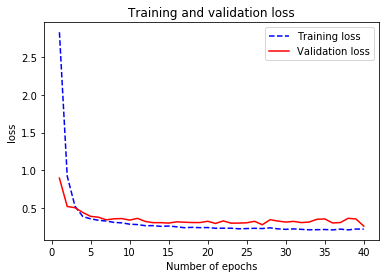

In [10]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'b--', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

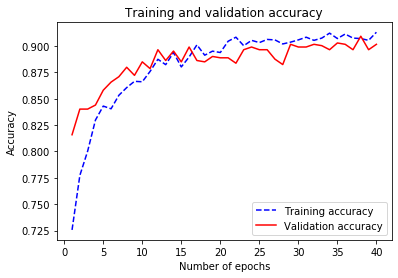

In [11]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], 'b--', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Gridsearch
We will use GridSearch to train separate instances of a model with different hyperparameters. Then, we will compare results to identify which combination of parameters produces the best resutls.

In [12]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict_classes(x_test)

    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print ("\nAccuracy:", accuracy)

    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print ("Precision:", p)
    print ("Recall:", r)
    print ("F-Score:", f1)
    print ("Confusion Matrix:")
    print (confusion_matrix(y_test, y_pred))
    
evaluate(model, x_test, y_test)

782/782 [==============================] - ETA:  - 0s 40us/step

Accuracy: 0.9015344977378845
Precision: 0.9367088607594937
Recall: 0.9411764705882353
F-Score: 0.9389373513084853
Confusion Matrix:
[[113  40]
 [ 37 592]]


In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

epochs = [10, 20, 30, 40]
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
batch_size = [32]
param_grid = dict(dropout_rate=dropout_rate, epochs=epochs, batch_size = batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1')

grid_result = grid.fit(x_train, y_train)

print ("Best accuracy: {0} using parameters {1}".format(grid_result.best_score_, grid_result.best_params_))

C:\Users\DEVARSHI\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/10
1562/1562 [==============================] - ETA: 5s - loss: 7.6605 - accuracy: 0.28 - ETA: 0s - loss: 3.6990 - accuracy: 0.64 - ETA: 0s - loss: 2.7013 - accuracy: 0.66 - 0s 164us/step - loss: 2.4237 - accuracy: 0.6684
Epoch 2/10
1562/1562 [==============================] - ETA: 0s - loss: 1.1096 - accuracy: 0.71 - ETA: 0s - loss: 0.8753 - accuracy: 0.75 - ETA: 0s - loss: 0.9186 - accuracy: 0.74 - ETA: 0s - loss: 0.8788 - accuracy: 0.74 - 0s 109us/step - loss: 0.8686 - accuracy: 0.7452
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.75 - ETA: 0s - loss: 0.6512 - accuracy: 0.78 - ETA: 0s - loss: 0.5853 - accuracy: 0.80 - ETA: 0s - loss: 0.5523 - accuracy: 0.81 - 0s 109us/step - loss: 0.5422 - accuracy: 0.8143
Epoch 4/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.78 - ETA: 0s - loss: 0.4414 - accuracy: 0.80 - ETA: 0s - loss: 0.4232 - accuracy: 0.80 - 0s 91us/step - loss: 0.4221 - accuracy: 0.81

Epoch 5/20
1562/1562 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.84 - ETA: 0s - loss: 0.4107 - accuracy: 0.80 - ETA: 0s - loss: 0.4184 - accuracy: 0.80 - 0s 87us/step - loss: 0.4155 - accuracy: 0.8009
Epoch 6/20
1562/1562 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.81 - ETA: 0s - loss: 0.3842 - accuracy: 0.84 - ETA: 0s - loss: 0.3843 - accuracy: 0.83 - 0s 93us/step - loss: 0.3753 - accuracy: 0.8393
Epoch 7/20
1562/1562 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.81 - ETA: 0s - loss: 0.3434 - accuracy: 0.85 - ETA: 0s - loss: 0.3483 - accuracy: 0.84 - 0s 84us/step - loss: 0.3343 - accuracy: 0.8560
Epoch 8/20
1562/1562 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.90 - ETA: 0s - loss: 0.3174 - accuracy: 0.84 - ETA: 0s - loss: 0.3277 - accuracy: 0.84 - 0s 82us/step - loss: 0.3303 - accuracy: 0.8444
Epoch 9/20
1562/1562 [==============================] - ETA: 0s - loss: 0.1791 - acc

1563/1563 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.96 - ETA: 0s - loss: 0.2590 - accuracy: 0.90 - ETA: 0s - loss: 0.2618 - accuracy: 0.89 - 0s 88us/step - loss: 0.2766 - accuracy: 0.8804
Epoch 20/20
1563/1563 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.90 - ETA: 0s - loss: 0.2509 - accuracy: 0.89 - ETA: 0s - loss: 0.2596 - accuracy: 0.88 - 0s 87us/step - loss: 0.2682 - accuracy: 0.8829
Epoch 1/20
1563/1563 [==============================] - ETA: 5s - loss: 13.2069 - accuracy: 0.281 - ETA: 0s - loss: 5.1175 - accuracy: 0.649 - ETA: 0s - loss: 3.8083 - accuracy: 0.67 - 0s 165us/step - loss: 3.3056 - accuracy: 0.6699
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 1.9754 - accuracy: 0.56 - ETA: 0s - loss: 1.0820 - accuracy: 0.66 - ETA: 0s - loss: 0.9826 - accuracy: 0.69 - ETA: 0s - loss: 0.9081 - accuracy: 0.72 - 0s 109us/step - loss: 0.9048 - accuracy: 0.7287
Epoch 3/20
1563/1563 [=========================

1562/1562 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.90 - ETA: 0s - loss: 0.2414 - accuracy: 0.89 - ETA: 0s - loss: 0.2479 - accuracy: 0.89 - 0s 88us/step - loss: 0.2498 - accuracy: 0.8912
Epoch 14/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.90 - ETA: 0s - loss: 0.2324 - accuracy: 0.89 - ETA: 0s - loss: 0.2372 - accuracy: 0.89 - 0s 85us/step - loss: 0.2526 - accuracy: 0.8860
Epoch 15/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.90 - ETA: 0s - loss: 0.2395 - accuracy: 0.89 - ETA: 0s - loss: 0.2433 - accuracy: 0.89 - 0s 84us/step - loss: 0.2426 - accuracy: 0.9008
Epoch 16/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.87 - ETA: 0s - loss: 0.2294 - accuracy: 0.90 - ETA: 0s - loss: 0.2357 - accuracy: 0.89 - 0s 83us/step - loss: 0.2318 - accuracy: 0.8976
Epoch 17/30
1562/1562 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.93 - ETA: 0s - loss: 0.2588 - accuracy: 0.89 - ETA: 0s - loss: 0.2751 - accuracy: 0.87 - 0s 85us/step - loss: 0.2782 - accuracy: 0.8746
Epoch 19/30
1563/1563 [==============================] - ETA: 0s - loss: 0.5168 - accuracy: 0.81 - ETA: 0s - loss: 0.2894 - accuracy: 0.86 - ETA: 0s - loss: 0.2751 - accuracy: 0.87 - 0s 84us/step - loss: 0.2695 - accuracy: 0.8810
Epoch 20/30
1563/1563 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.93 - ETA: 0s - loss: 0.2515 - accuracy: 0.90 - ETA: 0s - loss: 0.2807 - accuracy: 0.87 - 0s 83us/step - loss: 0.2739 - accuracy: 0.8810
Epoch 21/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.84 - ETA: 0s - loss: 0.2376 - accuracy: 0.89 - ETA: 0s - loss: 0.2624 - accuracy: 0.88 - 0s 83us/step - loss: 0.2567 - accuracy: 0.8880
Epoch 22/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2189 - accuracy: 0.84 - ETA: 0s - loss: 0.1949 - accuracy: 0.91 - ETA: 0s - loss: 0.2131 - accuracy: 0.90 - 0s 83us/step - loss: 0.2158 - accuracy: 0.8983
Epoch 24/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.87 - ETA: 0s - loss: 0.2008 - accuracy: 0.92 - ETA: 0s - loss: 0.2148 - accuracy: 0.90 - 0s 83us/step - loss: 0.2141 - accuracy: 0.9060
Epoch 25/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3364 - accuracy: 0.81 - ETA: 0s - loss: 0.2347 - accuracy: 0.89 - ETA: 0s - loss: 0.2218 - accuracy: 0.90 - 0s 89us/step - loss: 0.2214 - accuracy: 0.9047
Epoch 26/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.2273 - accuracy: 0.88 - ETA: 0s - loss: 0.2207 - accuracy: 0.90 - 0s 82us/step - loss: 0.2222 - accuracy: 0.8996
Epoch 27/30
1563/1563 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.4203 - accuracy: 0.84 - ETA: 0s - loss: 0.2587 - accuracy: 0.89 - ETA: 0s - loss: 0.2381 - accuracy: 0.90 - 0s 84us/step - loss: 0.2265 - accuracy: 0.9059
Epoch 29/40
1562/1562 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.96 - ETA: 0s - loss: 0.2233 - accuracy: 0.90 - ETA: 0s - loss: 0.2332 - accuracy: 0.89 - 0s 83us/step - loss: 0.2347 - accuracy: 0.8944
Epoch 30/40
1562/1562 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.93 - ETA: 0s - loss: 0.2520 - accuracy: 0.88 - ETA: 0s - loss: 0.2326 - accuracy: 0.89 - 0s 85us/step - loss: 0.2249 - accuracy: 0.8995
Epoch 31/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.90 - ETA: 0s - loss: 0.2160 - accuracy: 0.91 - ETA: 0s - loss: 0.2131 - accuracy: 0.90 - 0s 84us/step - loss: 0.2180 - accuracy: 0.9065
Epoch 32/40
1562/1562 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.90 - ETA: 0s - loss: 0.2318 - accuracy: 0.89 - ETA: 0s - loss: 0.2420 - accuracy: 0.89 - 0s 83us/step - loss: 0.2334 - accuracy: 0.8932
Epoch 24/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.87 - ETA: 0s - loss: 0.2701 - accuracy: 0.87 - ETA: 0s - loss: 0.2539 - accuracy: 0.88 - 0s 84us/step - loss: 0.2371 - accuracy: 0.8989
Epoch 25/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1644 - accuracy: 0.93 - ETA: 0s - loss: 0.2501 - accuracy: 0.90 - ETA: 0s - loss: 0.2374 - accuracy: 0.90 - 0s 84us/step - loss: 0.2395 - accuracy: 0.9015
Epoch 26/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - ETA: 0s - loss: 0.2527 - accuracy: 0.89 - ETA: 0s - loss: 0.2530 - accuracy: 0.89 - 0s 92us/step - loss: 0.2404 - accuracy: 0.8964
Epoch 27/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.81 - ETA: 0s - loss: 0.2712 - accuracy: 0.88 - ETA: 0s - loss: 0.2595 - accuracy: 0.88 - 0s 84us/step - loss: 0.2607 - accuracy: 0.8874
Epoch 19/40
1563/1563 [==============================] - ETA: 0s - loss: 0.4662 - accuracy: 0.84 - ETA: 0s - loss: 0.2307 - accuracy: 0.91 - ETA: 0s - loss: 0.2465 - accuracy: 0.90 - 0s 84us/step - loss: 0.2520 - accuracy: 0.9002
Epoch 20/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.93 - ETA: 0s - loss: 0.2901 - accuracy: 0.86 - ETA: 0s - loss: 0.2738 - accuracy: 0.87 - 0s 99us/step - loss: 0.2632 - accuracy: 0.8810
Epoch 21/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3676 - accuracy: 0.87 - ETA: 0s - loss: 0.2222 - accuracy: 0.90 - ETA: 0s - loss: 0.2519 - accuracy: 0.88 - 0s 91us/step - loss: 0.2596 - accuracy: 0.8848
Epoch 22/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 3.5656 - accuracy: 0.71 - ETA: 0s - loss: 2.0809 - accuracy: 0.77 - ETA: 0s - loss: 1.8327 - accuracy: 0.76 - 0s 83us/step - loss: 1.8047 - accuracy: 0.7665
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.81 - ETA: 0s - loss: 1.3291 - accuracy: 0.76 - ETA: 0s - loss: 1.3040 - accuracy: 0.78 - 0s 83us/step - loss: 1.2599 - accuracy: 0.7837
Epoch 5/10
1563/1563 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.84 - ETA: 0s - loss: 0.7760 - accuracy: 0.81 - ETA: 0s - loss: 0.7809 - accuracy: 0.81 - 0s 82us/step - loss: 0.7795 - accuracy: 0.8145
Epoch 6/10
1563/1563 [==============================] - ETA: 0s - loss: 1.1544 - accuracy: 0.65 - ETA: 0s - loss: 0.6602 - accuracy: 0.80 - ETA: 0s - loss: 0.5990 - accuracy: 0.82 - 0s 83us/step - loss: 0.5891 - accuracy: 0.8311
Epoch 7/10
1563/1563 [==============================] - ETA: 0s - loss: 0.6009 - accuracy: 0.81

1562/1562 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.90 - ETA: 0s - loss: 0.2307 - accuracy: 0.90 - ETA: 0s - loss: 0.2444 - accuracy: 0.90 - 0s 85us/step - loss: 0.2364 - accuracy: 0.8995
Epoch 19/20
1562/1562 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.90 - ETA: 0s - loss: 0.2206 - accuracy: 0.90 - ETA: 0s - loss: 0.2224 - accuracy: 0.90 - 0s 82us/step - loss: 0.2267 - accuracy: 0.9033
Epoch 20/20
1562/1562 [==============================] - ETA: 0s - loss: 0.1722 - accuracy: 0.93 - ETA: 0s - loss: 0.2386 - accuracy: 0.89 - ETA: 0s - loss: 0.2262 - accuracy: 0.90 - 0s 84us/step - loss: 0.2273 - accuracy: 0.9014
Epoch 1/20
1563/1563 [==============================] - ETA: 5s - loss: 17.5240 - accuracy: 0.531 - ETA: 0s - loss: 6.8929 - accuracy: 0.666 - ETA: 0s - loss: 5.5281 - accuracy: 0.66 - 0s 165us/step - loss: 4.8010 - accuracy: 0.6884
Epoch 2/20
1563/1563 [==============================] - ETA: 0s - loss: 3.1951 - accuracy

1563/1563 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.84 - ETA: 0s - loss: 0.2437 - accuracy: 0.89 - ETA: 0s - loss: 0.2615 - accuracy: 0.88 - 0s 85us/step - loss: 0.2687 - accuracy: 0.8874
Epoch 14/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2613 - accuracy: 0.87 - ETA: 0s - loss: 0.2875 - accuracy: 0.88 - ETA: 0s - loss: 0.2604 - accuracy: 0.88 - 0s 86us/step - loss: 0.2618 - accuracy: 0.8880
Epoch 15/20
1563/1563 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.93 - ETA: 0s - loss: 0.2315 - accuracy: 0.89 - ETA: 0s - loss: 0.2502 - accuracy: 0.88 - 0s 84us/step - loss: 0.2492 - accuracy: 0.8861
Epoch 16/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.87 - ETA: 0s - loss: 0.2630 - accuracy: 0.89 - ETA: 0s - loss: 0.2709 - accuracy: 0.88 - 0s 83us/step - loss: 0.2624 - accuracy: 0.8874
Epoch 17/20
1563/1563 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.87 - ETA: 0s - loss: 0.2342 - accuracy: 0.90 - ETA: 0s - loss: 0.2331 - accuracy: 0.90 - 0s 87us/step - loss: 0.2430 - accuracy: 0.8950
Epoch 29/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.90 - ETA: 0s - loss: 0.2610 - accuracy: 0.88 - ETA: 0s - loss: 0.2432 - accuracy: 0.89 - 0s 83us/step - loss: 0.2480 - accuracy: 0.8950
Epoch 30/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.93 - ETA: 0s - loss: 0.2237 - accuracy: 0.91 - ETA: 0s - loss: 0.2323 - accuracy: 0.90 - 0s 83us/step - loss: 0.2357 - accuracy: 0.9085
Epoch 1/30
1563/1563 [==============================] - ETA: 5s - loss: 7.7303 - accuracy: 0.62 - ETA: 0s - loss: 3.9173 - accuracy: 0.70 - ETA: 0s - loss: 3.2994 - accuracy: 0.69 - 0s 157us/step - loss: 3.0427 - accuracy: 0.6955
Epoch 2/30
1563/1563 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0

1563/1563 [==============================] - ETA: 0s - loss: 1.7578 - accuracy: 0.59 - ETA: 0s - loss: 1.1070 - accuracy: 0.75 - ETA: 0s - loss: 0.9525 - accuracy: 0.77 - 0s 84us/step - loss: 0.9579 - accuracy: 0.7722
Epoch 4/30
1563/1563 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.81 - ETA: 0s - loss: 0.6907 - accuracy: 0.78 - ETA: 0s - loss: 0.7246 - accuracy: 0.77 - 0s 83us/step - loss: 0.6982 - accuracy: 0.7831
Epoch 5/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.90 - ETA: 0s - loss: 0.5308 - accuracy: 0.78 - ETA: 0s - loss: 0.5090 - accuracy: 0.79 - 0s 83us/step - loss: 0.4888 - accuracy: 0.8068
Epoch 6/30
1563/1563 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.81 - ETA: 0s - loss: 0.4101 - accuracy: 0.84 - ETA: 0s - loss: 0.4340 - accuracy: 0.82 - 0s 82us/step - loss: 0.4509 - accuracy: 0.8177
Epoch 7/30
1563/1563 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.68

1562/1562 [==============================] - ETA: 0s - loss: 0.5305 - accuracy: 0.75 - ETA: 0s - loss: 0.3270 - accuracy: 0.85 - ETA: 0s - loss: 0.3484 - accuracy: 0.84 - 0s 83us/step - loss: 0.3523 - accuracy: 0.8406
Epoch 9/40
1562/1562 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.75 - ETA: 0s - loss: 0.3452 - accuracy: 0.83 - ETA: 0s - loss: 0.3308 - accuracy: 0.84 - 0s 89us/step - loss: 0.3452 - accuracy: 0.8464
Epoch 10/40
1562/1562 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.78 - ETA: 0s - loss: 0.3138 - accuracy: 0.84 - ETA: 0s - loss: 0.3181 - accuracy: 0.84 - 0s 86us/step - loss: 0.3166 - accuracy: 0.8521
Epoch 11/40
1562/1562 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.87 - ETA: 0s - loss: 0.2878 - accuracy: 0.86 - ETA: 0s - loss: 0.3076 - accuracy: 0.85 - 0s 87us/step - loss: 0.3078 - accuracy: 0.8579
Epoch 12/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0

1563/1563 [==============================] - ETA: 0s - loss: 1.3672 - accuracy: 0.78 - ETA: 0s - loss: 1.0476 - accuracy: 0.77 - ETA: 0s - loss: 0.9975 - accuracy: 0.78 - 0s 86us/step - loss: 1.0197 - accuracy: 0.7799
Epoch 4/40
1563/1563 [==============================] - ETA: 0s - loss: 0.9976 - accuracy: 0.68 - ETA: 0s - loss: 0.8259 - accuracy: 0.75 - ETA: 0s - loss: 0.7678 - accuracy: 0.78 - 0s 84us/step - loss: 0.7444 - accuracy: 0.7959
Epoch 5/40
1563/1563 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.81 - ETA: 0s - loss: 0.4634 - accuracy: 0.84 - ETA: 0s - loss: 0.5191 - accuracy: 0.84 - ETA: 0s - loss: 0.5225 - accuracy: 0.84 - 0s 133us/step - loss: 0.5033 - accuracy: 0.8464
Epoch 6/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.87 - ETA: 0s - loss: 0.5025 - accuracy: 0.83 - ETA: 0s - loss: 0.4934 - accuracy: 0.83 - 0s 90us/step - loss: 0.4897 - accuracy: 0.8349
Epoch 7/40
1563/1563 [==============================

1563/1563 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.71 - ETA: 0s - loss: 0.2436 - accuracy: 0.89 - ETA: 0s - loss: 0.2282 - accuracy: 0.90 - 0s 91us/step - loss: 0.2243 - accuracy: 0.9123
Epoch 38/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.96 - ETA: 0s - loss: 0.1932 - accuracy: 0.92 - ETA: 0s - loss: 0.2137 - accuracy: 0.91 - 0s 85us/step - loss: 0.2201 - accuracy: 0.9091
Epoch 39/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.90 - ETA: 0s - loss: 0.2263 - accuracy: 0.90 - ETA: 0s - loss: 0.2192 - accuracy: 0.91 - 0s 87us/step - loss: 0.2255 - accuracy: 0.9111
Epoch 40/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.87 - ETA: 0s - loss: 0.2280 - accuracy: 0.89 - ETA: 0s - loss: 0.2178 - accuracy: 0.90 - 0s 90us/step - loss: 0.2109 - accuracy: 0.9091
Epoch 1/40
1563/1563 [==============================] - ETA: 5s - loss: 7.5340 - accuracy: 0

1563/1563 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.90 - ETA: 0s - loss: 0.1730 - accuracy: 0.92 - ETA: 0s - loss: 0.2007 - accuracy: 0.91 - 0s 92us/step - loss: 0.2083 - accuracy: 0.9040
Epoch 33/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.93 - ETA: 0s - loss: 0.2245 - accuracy: 0.90 - ETA: 0s - loss: 0.2135 - accuracy: 0.91 - 0s 90us/step - loss: 0.2006 - accuracy: 0.9181
Epoch 34/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.93 - ETA: 0s - loss: 0.1989 - accuracy: 0.91 - ETA: 0s - loss: 0.1959 - accuracy: 0.91 - 0s 89us/step - loss: 0.1991 - accuracy: 0.9181
Epoch 35/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.87 - ETA: 0s - loss: 0.1961 - accuracy: 0.91 - ETA: 0s - loss: 0.2005 - accuracy: 0.91 - 0s 91us/step - loss: 0.1993 - accuracy: 0.9123
Epoch 36/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.87 - ETA: 0s - loss: 0.3548 - accuracy: 0.82 - ETA: 0s - loss: 0.3565 - accuracy: 0.81 - 0s 90us/step - loss: 0.3551 - accuracy: 0.8119
Epoch 8/10
1563/1563 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.68 - ETA: 0s - loss: 0.3755 - accuracy: 0.81 - ETA: 0s - loss: 0.3767 - accuracy: 0.82 - 0s 83us/step - loss: 0.3586 - accuracy: 0.8337
Epoch 9/10
1563/1563 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.84 - ETA: 0s - loss: 0.3493 - accuracy: 0.84 - ETA: 0s - loss: 0.3442 - accuracy: 0.84 - 0s 84us/step - loss: 0.3332 - accuracy: 0.8452
Epoch 10/10
1563/1563 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.87 - ETA: 0s - loss: 0.3111 - accuracy: 0.85 - ETA: 0s - loss: 0.3182 - accuracy: 0.85 - 0s 85us/step - loss: 0.3177 - accuracy: 0.8528
Epoch 1/20
1562/1562 [==============================] - ETA: 5s - loss: 7.2695 - accuracy: 0.6

1563/1563 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.78 - ETA: 0s - loss: 0.3020 - accuracy: 0.85 - ETA: 0s - loss: 0.3179 - accuracy: 0.84 - 0s 89us/step - loss: 0.3131 - accuracy: 0.8445
Epoch 13/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.84 - ETA: 0s - loss: 0.3050 - accuracy: 0.84 - ETA: 0s - loss: 0.2947 - accuracy: 0.85 - 0s 84us/step - loss: 0.3014 - accuracy: 0.8503
Epoch 14/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.78 - ETA: 0s - loss: 0.3077 - accuracy: 0.83 - ETA: 0s - loss: 0.2985 - accuracy: 0.84 - 0s 84us/step - loss: 0.3050 - accuracy: 0.8413
Epoch 15/20
1563/1563 [==============================] - ETA: 0s - loss: 0.3140 - accuracy: 0.84 - ETA: 0s - loss: 0.3077 - accuracy: 0.84 - ETA: 0s - loss: 0.3049 - accuracy: 0.84 - 0s 84us/step - loss: 0.3002 - accuracy: 0.8452
Epoch 16/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.87 - ETA: 0s - loss: 0.3105 - accuracy: 0.86 - ETA: 0s - loss: 0.3500 - accuracy: 0.86 - 0s 84us/step - loss: 0.3565 - accuracy: 0.8553
Epoch 8/30
1562/1562 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.81 - ETA: 0s - loss: 0.3966 - accuracy: 0.84 - ETA: 0s - loss: 0.3493 - accuracy: 0.85 - 0s 86us/step - loss: 0.3401 - accuracy: 0.8624
Epoch 9/30
1562/1562 [==============================] - ETA: 0s - loss: 0.1827 - accuracy: 0.93 - ETA: 0s - loss: 0.3053 - accuracy: 0.86 - ETA: 0s - loss: 0.3048 - accuracy: 0.87 - 0s 83us/step - loss: 0.3101 - accuracy: 0.8720
Epoch 10/30
1562/1562 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.81 - ETA: 0s - loss: 0.2851 - accuracy: 0.88 - ETA: 0s - loss: 0.2882 - accuracy: 0.87 - 0s 86us/step - loss: 0.2932 - accuracy: 0.8758
Epoch 11/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.

1563/1563 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.90 - ETA: 0s - loss: 0.3335 - accuracy: 0.83 - ETA: 0s - loss: 0.3171 - accuracy: 0.84 - 0s 85us/step - loss: 0.3218 - accuracy: 0.8407
Epoch 13/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.78 - ETA: 0s - loss: 0.3090 - accuracy: 0.84 - ETA: 0s - loss: 0.3040 - accuracy: 0.85 - 0s 83us/step - loss: 0.3090 - accuracy: 0.8522
Epoch 14/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.81 - ETA: 0s - loss: 0.3067 - accuracy: 0.86 - ETA: 0s - loss: 0.3032 - accuracy: 0.85 - 0s 84us/step - loss: 0.2998 - accuracy: 0.8573
Epoch 15/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.87 - ETA: 0s - loss: 0.2993 - accuracy: 0.84 - ETA: 0s - loss: 0.2894 - accuracy: 0.86 - 0s 84us/step - loss: 0.2869 - accuracy: 0.8624
Epoch 16/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.93 - ETA: 0s - loss: 0.2519 - accuracy: 0.88 - ETA: 0s - loss: 0.2494 - accuracy: 0.88 - 0s 84us/step - loss: 0.2566 - accuracy: 0.8829
Epoch 18/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.93 - ETA: 0s - loss: 0.2569 - accuracy: 0.88 - ETA: 0s - loss: 0.2524 - accuracy: 0.88 - 0s 86us/step - loss: 0.2570 - accuracy: 0.8816
Epoch 19/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.90 - ETA: 0s - loss: 0.2424 - accuracy: 0.88 - ETA: 0s - loss: 0.2510 - accuracy: 0.88 - 0s 86us/step - loss: 0.2446 - accuracy: 0.8900
Epoch 20/30
1563/1563 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.93 - ETA: 0s - loss: 0.2343 - accuracy: 0.90 - ETA: 0s - loss: 0.2531 - accuracy: 0.89 - 0s 85us/step - loss: 0.2559 - accuracy: 0.8919
Epoch 21/30
1563/1563 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.96 - ETA: 0s - loss: 0.2527 - accuracy: 0.89 - ETA: 0s - loss: 0.2794 - accuracy: 0.87 - 0s 84us/step - loss: 0.2829 - accuracy: 0.8790
Epoch 23/40
1562/1562 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.93 - ETA: 0s - loss: 0.2654 - accuracy: 0.89 - ETA: 0s - loss: 0.2691 - accuracy: 0.88 - 0s 85us/step - loss: 0.2710 - accuracy: 0.8867
Epoch 24/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.90 - ETA: 0s - loss: 0.2590 - accuracy: 0.87 - ETA: 0s - loss: 0.2579 - accuracy: 0.87 - 0s 85us/step - loss: 0.2621 - accuracy: 0.8758
Epoch 25/40
1562/1562 [==============================] - ETA: 0s - loss: 0.6138 - accuracy: 0.81 - ETA: 0s - loss: 0.2835 - accuracy: 0.88 - ETA: 0s - loss: 0.2650 - accuracy: 0.88 - 0s 85us/step - loss: 0.2627 - accuracy: 0.8899
Epoch 26/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.75 - ETA: 0s - loss: 0.2932 - accuracy: 0.85 - ETA: 0s - loss: 0.3024 - accuracy: 0.84 - 0s 85us/step - loss: 0.3081 - accuracy: 0.8464
Epoch 18/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3700 - accuracy: 0.84 - ETA: 0s - loss: 0.3539 - accuracy: 0.83 - ETA: 0s - loss: 0.3137 - accuracy: 0.85 - 0s 86us/step - loss: 0.3112 - accuracy: 0.8599
Epoch 19/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.87 - ETA: 0s - loss: 0.2945 - accuracy: 0.86 - ETA: 0s - loss: 0.3108 - accuracy: 0.85 - 0s 85us/step - loss: 0.3104 - accuracy: 0.8567
Epoch 20/40
1563/1563 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.81 - ETA: 0s - loss: 0.3198 - accuracy: 0.84 - ETA: 0s - loss: 0.3120 - accuracy: 0.85 - 0s 83us/step - loss: 0.3102 - accuracy: 0.8605
Epoch 21/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.81 - ETA: 0s - loss: 0.2913 - accuracy: 0.87 - ETA: 0s - loss: 0.2841 - accuracy: 0.87 - 0s 86us/step - loss: 0.2900 - accuracy: 0.8733
Epoch 13/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.87 - ETA: 0s - loss: 0.3120 - accuracy: 0.83 - ETA: 0s - loss: 0.3004 - accuracy: 0.85 - 0s 85us/step - loss: 0.3049 - accuracy: 0.8548
Epoch 14/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.90 - ETA: 0s - loss: 0.2863 - accuracy: 0.87 - ETA: 0s - loss: 0.2780 - accuracy: 0.87 - 0s 83us/step - loss: 0.2816 - accuracy: 0.8759
Epoch 15/40
1563/1563 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.81 - ETA: 0s - loss: 0.3135 - accuracy: 0.86 - ETA: 0s - loss: 0.2800 - accuracy: 0.87 - 0s 85us/step - loss: 0.2814 - accuracy: 0.8701
Epoch 16/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.87 - ETA: 0s - loss: 0.3672 - accuracy: 0.83 - ETA: 0s - loss: 0.4317 - accuracy: 0.81 - 0s 83us/step - loss: 0.4175 - accuracy: 0.8271
Epoch 8/10
1562/1562 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.78 - ETA: 0s - loss: 0.3840 - accuracy: 0.82 - ETA: 0s - loss: 0.3860 - accuracy: 0.82 - 0s 85us/step - loss: 0.3859 - accuracy: 0.8188
Epoch 9/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3555 - accuracy: 0.87 - ETA: 0s - loss: 0.3784 - accuracy: 0.84 - ETA: 0s - loss: 0.3712 - accuracy: 0.83 - 0s 82us/step - loss: 0.3688 - accuracy: 0.8323
Epoch 10/10
1562/1562 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.87 - ETA: 0s - loss: 0.3451 - accuracy: 0.83 - ETA: 0s - loss: 0.3454 - accuracy: 0.84 - 0s 87us/step - loss: 0.3589 - accuracy: 0.8374
Epoch 1/10
1563/1563 [==============================] - ETA: 5s - loss: 6.5715 - accuracy: 0.5

1562/1562 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.90 - ETA: 0s - loss: 0.3827 - accuracy: 0.83 - ETA: 0s - loss: 0.3583 - accuracy: 0.83 - 0s 84us/step - loss: 0.3573 - accuracy: 0.8380
Epoch 13/20
1562/1562 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.84 - ETA: 0s - loss: 0.3265 - accuracy: 0.83 - ETA: 0s - loss: 0.3420 - accuracy: 0.82 - 0s 84us/step - loss: 0.3399 - accuracy: 0.8335
Epoch 14/20
1562/1562 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.65 - ETA: 0s - loss: 0.3662 - accuracy: 0.83 - ETA: 0s - loss: 0.3436 - accuracy: 0.84 - 0s 91us/step - loss: 0.3345 - accuracy: 0.8476
Epoch 15/20
1562/1562 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.75 - ETA: 0s - loss: 0.3496 - accuracy: 0.83 - ETA: 0s - loss: 0.3413 - accuracy: 0.83 - 0s 85us/step - loss: 0.3377 - accuracy: 0.8406
Epoch 16/20
1562/1562 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.81 - ETA: 0s - loss: 0.3707 - accuracy: 0.80 - ETA: 0s - loss: 0.3716 - accuracy: 0.80 - 0s 89us/step - loss: 0.3694 - accuracy: 0.8068
Epoch 8/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 0.81 - ETA: 0s - loss: 0.3524 - accuracy: 0.83 - ETA: 0s - loss: 0.3478 - accuracy: 0.82 - 0s 88us/step - loss: 0.3481 - accuracy: 0.8241
Epoch 9/20
1563/1563 [==============================] - ETA: 0s - loss: 0.4271 - accuracy: 0.84 - ETA: 0s - loss: 0.3402 - accuracy: 0.84 - ETA: 0s - loss: 0.3324 - accuracy: 0.83 - 0s 86us/step - loss: 0.3377 - accuracy: 0.8356
Epoch 10/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.87 - ETA: 0s - loss: 0.3343 - accuracy: 0.81 - ETA: 0s - loss: 0.3241 - accuracy: 0.83 - 0s 85us/step - loss: 0.3310 - accuracy: 0.8253
Epoch 11/20
1563/1563 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.

1562/1562 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.87 - ETA: 0s - loss: 0.3130 - accuracy: 0.86 - ETA: 0s - loss: 0.3011 - accuracy: 0.86 - 0s 85us/step - loss: 0.2993 - accuracy: 0.8630
Epoch 23/30
1562/1562 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.90 - ETA: 0s - loss: 0.2873 - accuracy: 0.86 - ETA: 0s - loss: 0.2853 - accuracy: 0.86 - 0s 83us/step - loss: 0.2820 - accuracy: 0.8713
Epoch 24/30
1562/1562 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.84 - ETA: 0s - loss: 0.2721 - accuracy: 0.87 - ETA: 0s - loss: 0.2697 - accuracy: 0.86 - 0s 86us/step - loss: 0.2901 - accuracy: 0.8553
Epoch 25/30
1562/1562 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.84 - ETA: 0s - loss: 0.2852 - accuracy: 0.85 - ETA: 0s - loss: 0.2918 - accuracy: 0.85 - 0s 85us/step - loss: 0.2896 - accuracy: 0.8611
Epoch 26/30
1562/1562 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.87 - ETA: 0s - loss: 0.2502 - accuracy: 0.89 - ETA: 0s - loss: 0.2621 - accuracy: 0.88 - 0s 84us/step - loss: 0.2633 - accuracy: 0.8868
Epoch 28/30
1563/1563 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.96 - ETA: 0s - loss: 0.2667 - accuracy: 0.88 - ETA: 0s - loss: 0.2547 - accuracy: 0.88 - 0s 92us/step - loss: 0.2628 - accuracy: 0.8855
Epoch 29/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.84 - ETA: 0s - loss: 0.2709 - accuracy: 0.87 - ETA: 0s - loss: 0.2475 - accuracy: 0.88 - 0s 87us/step - loss: 0.2529 - accuracy: 0.8823
Epoch 30/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3120 - accuracy: 0.87 - ETA: 0s - loss: 0.2620 - accuracy: 0.87 - ETA: 0s - loss: 0.2454 - accuracy: 0.88 - 0s 84us/step - loss: 0.2450 - accuracy: 0.8842
Epoch 1/30
1563/1563 [==============================] - ETA: 5s - loss: 8.1982 - accuracy: 0

1562/1562 [==============================] - ETA: 0s - loss: 5.6853 - accuracy: 0.65 - ETA: 0s - loss: 5.3230 - accuracy: 0.70 - ETA: 0s - loss: 4.6910 - accuracy: 0.68 - 0s 86us/step - loss: 4.4762 - accuracy: 0.6921
Epoch 3/40
1562/1562 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.65 - ETA: 0s - loss: 2.2464 - accuracy: 0.71 - ETA: 0s - loss: 1.9839 - accuracy: 0.71 - 0s 83us/step - loss: 1.8922 - accuracy: 0.7183
Epoch 4/40
1562/1562 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.68 - ETA: 0s - loss: 1.1730 - accuracy: 0.75 - ETA: 0s - loss: 1.1769 - accuracy: 0.74 - 0s 85us/step - loss: 1.1031 - accuracy: 0.7529
Epoch 5/40
1562/1562 [==============================] - ETA: 0s - loss: 1.2324 - accuracy: 0.71 - ETA: 0s - loss: 0.8530 - accuracy: 0.76 - ETA: 0s - loss: 0.8201 - accuracy: 0.77 - 0s 84us/step - loss: 0.8192 - accuracy: 0.7772
Epoch 6/40
1562/1562 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.84

1562/1562 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.90 - ETA: 0s - loss: 0.2443 - accuracy: 0.89 - ETA: 0s - loss: 0.2409 - accuracy: 0.89 - 0s 85us/step - loss: 0.2390 - accuracy: 0.8976
Epoch 38/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.81 - ETA: 0s - loss: 0.2042 - accuracy: 0.90 - ETA: 0s - loss: 0.2247 - accuracy: 0.89 - 0s 84us/step - loss: 0.2330 - accuracy: 0.8944
Epoch 39/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.87 - ETA: 0s - loss: 0.2374 - accuracy: 0.90 - ETA: 0s - loss: 0.2352 - accuracy: 0.89 - 0s 85us/step - loss: 0.2353 - accuracy: 0.8969
Epoch 40/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.90 - ETA: 0s - loss: 0.2347 - accuracy: 0.90 - ETA: 0s - loss: 0.2367 - accuracy: 0.89 - 0s 83us/step - loss: 0.2342 - accuracy: 0.9020
Epoch 1/40
1563/1563 [==============================] - ETA: 5s - loss: 4.1598 - accuracy: 0

1563/1563 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.87 - ETA: 0s - loss: 0.2333 - accuracy: 0.89 - ETA: 0s - loss: 0.2456 - accuracy: 0.89 - 0s 83us/step - loss: 0.2486 - accuracy: 0.8957
Epoch 33/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.93 - ETA: 0s - loss: 0.2379 - accuracy: 0.88 - ETA: 0s - loss: 0.2497 - accuracy: 0.89 - 0s 91us/step - loss: 0.2468 - accuracy: 0.8912
Epoch 34/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.93 - ETA: 0s - loss: 0.2431 - accuracy: 0.90 - ETA: 0s - loss: 0.2420 - accuracy: 0.89 - 0s 85us/step - loss: 0.2390 - accuracy: 0.8976
Epoch 35/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.93 - ETA: 0s - loss: 0.2223 - accuracy: 0.91 - ETA: 0s - loss: 0.2537 - accuracy: 0.89 - 0s 84us/step - loss: 0.2477 - accuracy: 0.9002
Epoch 36/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.87 - ETA: 0s - loss: 0.2669 - accuracy: 0.87 - ETA: 0s - loss: 0.2763 - accuracy: 0.87 - 0s 86us/step - loss: 0.2761 - accuracy: 0.8701
Epoch 28/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.78 - ETA: 0s - loss: 0.2993 - accuracy: 0.85 - ETA: 0s - loss: 0.2855 - accuracy: 0.86 - 0s 84us/step - loss: 0.2820 - accuracy: 0.8688
Epoch 29/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.84 - ETA: 0s - loss: 0.2700 - accuracy: 0.87 - ETA: 0s - loss: 0.2588 - accuracy: 0.88 - 0s 84us/step - loss: 0.2625 - accuracy: 0.8823
Epoch 30/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.90 - ETA: 0s - loss: 0.2589 - accuracy: 0.87 - ETA: 0s - loss: 0.2608 - accuracy: 0.87 - 0s 85us/step - loss: 0.2567 - accuracy: 0.8810
Epoch 31/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2961 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 2.4536 - accuracy: 0.75 - ETA: 0s - loss: 2.5998 - accuracy: 0.75 - ETA: 0s - loss: 2.3884 - accuracy: 0.71 - 0s 87us/step - loss: 2.1793 - accuracy: 0.7185
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 2.9698 - accuracy: 0.59 - ETA: 0s - loss: 1.3869 - accuracy: 0.72 - ETA: 0s - loss: 1.1281 - accuracy: 0.72 - 0s 85us/step - loss: 1.0419 - accuracy: 0.7319
Epoch 4/10
1563/1563 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.71 - ETA: 0s - loss: 0.5843 - accuracy: 0.75 - ETA: 0s - loss: 0.5715 - accuracy: 0.76 - 0s 84us/step - loss: 0.5549 - accuracy: 0.7671
Epoch 5/10
1563/1563 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.90 - ETA: 0s - loss: 0.4341 - accuracy: 0.80 - ETA: 0s - loss: 0.4375 - accuracy: 0.80 - 0s 85us/step - loss: 0.4386 - accuracy: 0.8023
Epoch 6/10
1563/1563 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.78

1563/1563 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.87 - ETA: 0s - loss: 0.3685 - accuracy: 0.82 - ETA: 0s - loss: 0.3705 - accuracy: 0.82 - 0s 86us/step - loss: 0.4024 - accuracy: 0.8068
Epoch 8/20
1563/1563 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.84 - ETA: 0s - loss: 0.3728 - accuracy: 0.81 - ETA: 0s - loss: 0.3842 - accuracy: 0.81 - 0s 97us/step - loss: 0.3897 - accuracy: 0.8157
Epoch 9/20
1563/1563 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.78 - ETA: 0s - loss: 0.3631 - accuracy: 0.81 - ETA: 0s - loss: 0.3620 - accuracy: 0.81 - 0s 88us/step - loss: 0.3652 - accuracy: 0.8151
Epoch 10/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.87 - ETA: 0s - loss: 0.3521 - accuracy: 0.83 - ETA: 0s - loss: 0.3607 - accuracy: 0.82 - 0s 86us/step - loss: 0.3555 - accuracy: 0.8253
Epoch 11/20
1563/1563 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.

1562/1562 [==============================] - ETA: 0s - loss: 2.4640 - accuracy: 0.59 - ETA: 0s - loss: 2.0709 - accuracy: 0.68 - ETA: 0s - loss: 1.7622 - accuracy: 0.71 - 0s 84us/step - loss: 1.6296 - accuracy: 0.7125
Epoch 3/30
1562/1562 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.75 - ETA: 0s - loss: 0.8455 - accuracy: 0.72 - ETA: 0s - loss: 0.7931 - accuracy: 0.73 - 0s 86us/step - loss: 0.7611 - accuracy: 0.7375
Epoch 4/30
1562/1562 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.75 - ETA: 0s - loss: 0.5263 - accuracy: 0.77 - ETA: 0s - loss: 0.5313 - accuracy: 0.77 - 0s 87us/step - loss: 0.5106 - accuracy: 0.7817
Epoch 5/30
1562/1562 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.81 - ETA: 0s - loss: 0.4625 - accuracy: 0.78 - ETA: 0s - loss: 0.4956 - accuracy: 0.78 - 0s 84us/step - loss: 0.4973 - accuracy: 0.7881
Epoch 6/30
1562/1562 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.84

1563/1563 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.84 - ETA: 0s - loss: 0.4721 - accuracy: 0.83 - ETA: 0s - loss: 0.4484 - accuracy: 0.82 - 0s 86us/step - loss: 0.4515 - accuracy: 0.8196
Epoch 8/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.84 - ETA: 0s - loss: 0.3996 - accuracy: 0.80 - ETA: 0s - loss: 0.4067 - accuracy: 0.80 - 0s 86us/step - loss: 0.4106 - accuracy: 0.8100
Epoch 9/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.90 - ETA: 0s - loss: 0.3801 - accuracy: 0.82 - ETA: 0s - loss: 0.3866 - accuracy: 0.81 - 0s 85us/step - loss: 0.3776 - accuracy: 0.8183
Epoch 10/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.93 - ETA: 0s - loss: 0.4014 - accuracy: 0.81 - ETA: 0s - loss: 0.3893 - accuracy: 0.81 - 0s 86us/step - loss: 0.3908 - accuracy: 0.8119
Epoch 11/30
1563/1563 [==============================] - ETA: 0s - loss: 0.4588 - accuracy: 0.

1563/1563 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.90 - ETA: 0s - loss: 0.3737 - accuracy: 0.82 - ETA: 0s - loss: 0.3672 - accuracy: 0.81 - 0s 86us/step - loss: 0.3617 - accuracy: 0.8177
Epoch 13/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.87 - ETA: 0s - loss: 0.3558 - accuracy: 0.82 - ETA: 0s - loss: 0.3516 - accuracy: 0.83 - 0s 85us/step - loss: 0.3552 - accuracy: 0.8273
Epoch 14/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.84 - ETA: 0s - loss: 0.3262 - accuracy: 0.83 - ETA: 0s - loss: 0.3291 - accuracy: 0.82 - 0s 87us/step - loss: 0.3339 - accuracy: 0.8266
Epoch 15/30
1563/1563 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.90 - ETA: 0s - loss: 0.3370 - accuracy: 0.83 - ETA: 0s - loss: 0.3356 - accuracy: 0.82 - 0s 87us/step - loss: 0.3361 - accuracy: 0.8279
Epoch 16/30
1563/1563 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 

1562/1562 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.84 - ETA: 0s - loss: 0.2916 - accuracy: 0.86 - ETA: 0s - loss: 0.3050 - accuracy: 0.85 - 0s 85us/step - loss: 0.3138 - accuracy: 0.8451
Epoch 18/40
1562/1562 [==============================] - ETA: 0s - loss: 0.4216 - accuracy: 0.78 - ETA: 0s - loss: 0.3182 - accuracy: 0.83 - ETA: 0s - loss: 0.3178 - accuracy: 0.82 - 0s 84us/step - loss: 0.3214 - accuracy: 0.8291
Epoch 19/40
1562/1562 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.84 - ETA: 0s - loss: 0.3077 - accuracy: 0.82 - ETA: 0s - loss: 0.2968 - accuracy: 0.83 - 0s 86us/step - loss: 0.3030 - accuracy: 0.8361
Epoch 20/40
1562/1562 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.75 - ETA: 0s - loss: 0.3212 - accuracy: 0.83 - ETA: 0s - loss: 0.3103 - accuracy: 0.84 - 0s 84us/step - loss: 0.3132 - accuracy: 0.8444
Epoch 21/40
1562/1562 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.78 - ETA: 0s - loss: 0.3495 - accuracy: 0.83 - ETA: 0s - loss: 0.3587 - accuracy: 0.82 - 0s 87us/step - loss: 0.3686 - accuracy: 0.8228
Epoch 13/40
1563/1563 [==============================] - ETA: 0s - loss: 0.1022 - accuracy: 0.96 - ETA: 0s - loss: 0.3133 - accuracy: 0.83 - ETA: 0s - loss: 0.3415 - accuracy: 0.82 - 0s 91us/step - loss: 0.3451 - accuracy: 0.8234
Epoch 14/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.78 - ETA: 0s - loss: 0.3534 - accuracy: 0.83 - ETA: 0s - loss: 0.3540 - accuracy: 0.84 - 0s 84us/step - loss: 0.3551 - accuracy: 0.8362
Epoch 15/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.81 - ETA: 0s - loss: 0.3268 - accuracy: 0.84 - ETA: 0s - loss: 0.3343 - accuracy: 0.82 - 0s 85us/step - loss: 0.3444 - accuracy: 0.8221
Epoch 16/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 

1563/1563 [==============================] - ETA: 0s - loss: 0.5721 - accuracy: 0.78 - ETA: 0s - loss: 0.4085 - accuracy: 0.78 - ETA: 0s - loss: 0.4028 - accuracy: 0.79 - 0s 85us/step - loss: 0.3967 - accuracy: 0.8017
Epoch 8/40
1563/1563 [==============================] - ETA: 0s - loss: 0.5278 - accuracy: 0.78 - ETA: 0s - loss: 0.3765 - accuracy: 0.80 - ETA: 0s - loss: 0.3783 - accuracy: 0.80 - 0s 85us/step - loss: 0.3830 - accuracy: 0.7953
Epoch 9/40
1563/1563 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.78 - ETA: 0s - loss: 0.3897 - accuracy: 0.79 - ETA: 0s - loss: 0.3814 - accuracy: 0.80 - 0s 84us/step - loss: 0.3937 - accuracy: 0.7959
Epoch 10/40
1563/1563 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.84 - ETA: 0s - loss: 0.3869 - accuracy: 0.76 - ETA: 0s - loss: 0.3930 - accuracy: 0.78 - 0s 86us/step - loss: 0.3840 - accuracy: 0.7940
Epoch 11/40
1563/1563 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.

2344/2344 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.87 - ETA: 0s - loss: 0.8960 - accuracy: 0.76 - ETA: 0s - loss: 0.9072 - accuracy: 0.75 - ETA: 0s - loss: 0.7982 - accuracy: 0.75 - 0s 85us/step - loss: 0.7567 - accuracy: 0.7683
Epoch 3/40
2344/2344 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.84 - ETA: 0s - loss: 0.4280 - accuracy: 0.79 - ETA: 0s - loss: 0.4210 - accuracy: 0.80 - ETA: 0s - loss: 0.4289 - accuracy: 0.81 - 0s 83us/step - loss: 0.4448 - accuracy: 0.8097
Epoch 4/40
2344/2344 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.78 - ETA: 0s - loss: 0.4029 - accuracy: 0.81 - ETA: 0s - loss: 0.3954 - accuracy: 0.81 - ETA: 0s - loss: 0.3775 - accuracy: 0.82 - 0s 84us/step - loss: 0.3932 - accuracy: 0.8264
Epoch 5/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.93 - ETA: 0s - loss: 0.4171 - accuracy: 0.80 - ETA: 0s - loss: 0.3845 - accuracy: 0.83 - ETA: 0s - loss: 

2344/2344 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.96 - ETA: 0s - loss: 0.2013 - accuracy: 0.91 - ETA: 0s - loss: 0.2139 - accuracy: 0.91 - ETA: 0s - loss: 0.2156 - accuracy: 0.91 - ETA: 0s - loss: 0.2277 - accuracy: 0.90 - 0s 94us/step - loss: 0.2268 - accuracy: 0.9040
Epoch 32/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.93 - ETA: 0s - loss: 0.2476 - accuracy: 0.90 - ETA: 0s - loss: 0.2237 - accuracy: 0.90 - ETA: 0s - loss: 0.2237 - accuracy: 0.90 - ETA: 0s - loss: 0.2268 - accuracy: 0.90 - 0s 94us/step - loss: 0.2254 - accuracy: 0.9032
Epoch 33/40
2344/2344 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.90 - ETA: 0s - loss: 0.2137 - accuracy: 0.91 - ETA: 0s - loss: 0.2212 - accuracy: 0.91 - ETA: 0s - loss: 0.2184 - accuracy: 0.91 - 0s 84us/step - loss: 0.2206 - accuracy: 0.9100
Epoch 34/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1557 - accuracy: 0.87 - ETA: 0s - los

In [17]:
# model.load_weights('models/ffn.hdf5') # load weights to model